In [1]:
from collections import defaultdict
from IPython.display import display
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk.stem.wordnet as wordnet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sklearn
import string
import time

In [2]:
sw = set(stopwords.words('english'))
wnl = wordnet.WordNetLemmatizer()

In [3]:
pd.set_option('max_columns', 40)
vcr_df = pd.read_csv('../flaskr/flaskr/data_management/temp_data/faculty_vcr.csv', delimiter="~")
vcr_df.head()

,faculty_name,faculty_profile_url,l_expertise,department,title_name,faculty_site_url,lab_url,faculty_email,description,description_links,article_date_1,title_of_news_1,link_to_news_1,description_teaser_1,article_date_2,title_of_news_2,link_to_news_2,description_teaser_2,article_date_3,title_of_news_3,link_to_news_3,description_teaser_3,article_date_4,title_of_news_4,link_to_news_4,description_teaser_4,article_date_5,title_of_news_5,link_to_news_5,description_teaser_5
0,David A. Aaker,/faculty/david-aaker,"business,marketing,branding",Haas School of Business,Professor of Marketing and Public Policy,http://www.haas.berkeley.edu/faculty/aaker.html,http://groups.haas.berkeley.edu/marketing/,aaker@haas.berkeley.edu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pieter Abbeel,/faculty/pieter-abbeel,"robotics,machine learning",Division of Computer Science/EECS,Professor,http://www.cs.berkeley.edu/~pabbeel,NaN,pabbeel@cs.berkeley.edu,Robotics and Machine Learning.,NaN,"February 22, 2016",“Deep Learning”: A Giant Step for Robots,/bakarfellows/profile/pieter_abbeel,Bakar Fellow Pieter Abbeel studies deep lear...,"February 19, 2016",Three young faculty members honored by White ...,/news/three-young-faculty-members-honored-whit...,Three UC Berkeley faculty members named as r...,"May 21, 2015",New ‘deep learning’ technique enables robot m...,/news/new-deep-learning-technique-enables-robo...,UC Berkeley researchers have developed algor...,"December 17, 2012",Big NSF grant funds research into training ro...,/news/big-nsf-grant-funds-research-training-ro...,"What if robots and humans, working together,...","August 23, 2011",UC Berkeley robotics expert named among world...,/news/uc-berkeley-robotics-expert-named-among-...,"Pieter Abbeel, a UC Berkeley, professor know..."
2,Elizabeth Abel,/faculty/elizabeth-abel,"feminist theory,psychoanalysis,Virginia Woolf,...",Department of English,Professor of English,http://english.berkeley.edu/profiles/5,NaN,eabel@uclink.berkeley.edu,Elizabeth Abel's general research interest is...,NaN,"February 15, 2011","Jim Crow signs as symbols of subjugation, tro...",/news/jim-crow-signs-symbols-subjugation-troph...,"In the mid 1960s, landmark laws brought an o...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Dor Abrahamson,/faculty/dor-abrahamson,"mathematical cognition,design-based research,m...",Graduate School of Education,Associate Professor of Cognition and Development,http://gse.berkeley.edu/people/dor-abrahamson,http://edrl.berkeley.edu/,dor@berkeley.edu,Dor Abrahamson studies the process of mathema...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Norman Abrahamson,/faculty/norman-abrahamson,"civil and environmental engineering,earthquake...",Department of Civil and Environmental Engineering,Adjunct Professor of Civil and Environmental E...,http://www.ce.berkeley.edu/faculty/faculty.php...,NaN,naa3@earthlink.net,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
cleaned_df = pd.read_csv('../flaskr/flaskr/data_management/temp_data/complete_cleaned_faculty_webpages.csv', delimiter=",")
cleaned_df = cleaned_df[pd.notnull(cleaned_df['cleaned_str_text'])]
cleaned_df.reset_index(drop=True)
cleaned_df.head()

,full_name,personal_webpage_url,cleaned_str_text
0,john ellwood,http://sph.berkeley.edu/john-ellwood,john ellwood professor emeritus research inter...
1,iris mauss,http://psychology.berkeley.edu//people/iris-mauss,associate professor address imauss education s...
2,polina lishko,https://mcb.berkeley.edu/faculty/CDB/lishkop.html,polina lishko info assistant professor cell de...
3,david lindberg,https://ib.berkeley.edu/people/faculty/lindbergd,professor drl lab webpage labs lindberg drl fu...
4,raymond lifchez,https://ced.berkeley.edu/ced/faculty-staff/ray...,raymond lifchez professor architecture city re...


In [5]:
grants_df = pd.read_csv('../flaskr/flaskr/data_management/temp_data/grants_gov.csv', delimiter="~")
grants_df.head()

,OpportunityID,OpportunityTitle,OpportunityNumber,OpportunityCategory,FundingInstrumentType,CategoryOfFundingActivity,CategoryExplanation,CFDANumbers,EligibleApplicants,AdditionalInformationOnEligibility,AgencyCode,AgencyName,PostDate,CloseDate,LastUpdatedDate,AwardCeiling,AwardFloor,EstimatedTotalProgramFunding,ExpectedNumberOfAwards,Description,Version,CostSharingOrMatchingRequirement,ArchiveDate,GrantorContactEmail,GrantorContactEmailDescription,GrantorContactText,AdditionalInformationURL,AdditionalInformationText,OpportunityCategoryExplanation,CloseDateExplanation
0,262148,Establishment of the Edmund S. Muskie Graduate...,SCAPPD-14-AW-161-SCA-08152014,D,CA,O,Public Diplomacy,19.040,25,Eligibility for U.S. institutions is limited t...,DOS-SA,Bureau of South and Central Asian Affairs,08-15-2014,09-04-2014,08-20-2014,600000.0,400000.0,600000.0,1.0,The Office of Press and Public Diplomacy of th...,Synopsis 2,No,10-04-2014,DelageEM@state.gov,Inquiries,"Ellen Delage, Bureau of South and Central Asia...",NaN,NaN,NaN,NaN
1,262149,Eradication of Yellow Crazy Ants on Johnston A...,F14AS00402,D,CA,"AG,ENV,NR",NaN,15.608,99,The recipient has already been selected for th...,DOI-FWS,Fish and Wildlife Service,08-15-2014,08-22-2014,08-15-2014,0.0,0.0,0.0,NaN,Funds under this award are to be used for the ...,Synopsis 1,No,08-23-2014,Connie_Sauer@fws.gov,Connie_Sauer@fws.gov,"Connie Sauer, 503-490-0827&lt;br/&gt;Connie_Sa...",http://www.grants.gov/,http://www.grants.gov/,NaN,NaN
2,131073,"Cooperative Ecosystem Studies Unit, Piedmont S...",G12AS20003,D,CA,ST,NaN,15.808,25,This financial assistance opportunity is being...,DOI-USGS1,Geological Survey,11-17-2011,11-29-2011,11-28-2011,0.0,0.0,31900.0,1.0,The USGS Southeast Ecological Science Center s...,Synopsis 2,No,12-17-2011,fgraves@usgs.gov,fgraves@usgs.gov,"Faith Graves, 703-648-7356&lt;br/&gt;fgraves@u...",http://www.grants.gov/,http://www.grants.gov/,NaN,NaN
3,196613,OVW FY 2012 Training and Technical Assistance ...,OVW-2012-3380,D,CA,LJL,NaN,16.526,"06,12",NaN,USDOJ-OJP-OVW,Office on Violence Against Women,08-29-2012,10-15-2012,08-29-2012,2500000.0,NaN,2500000.0,1.0,There are different statutory and regulatory r...,Synopsis 1,No,11-14-2012,Christina.Murray@usdoj.gov,Christina.Murray@usdoj.gov,Christina Murray &lt;br/&gt;Phone 202-307-0344,http://www.ovw.usdoj.gov/docs/grantee-reportin...,OVW FY 2012 Training and Technical Assistance ...,CategoryExplanation,NaN
4,65553,Affordable Care Act (ACA): Childhood Obesity R...,RFA-DP-11-007,D,CA,HL,NaN,93.535,99,NaN,HHS-CDC-HHSCDCERA,Centers for Disease Control and Prevention - ERA,01-19-2011,04-25-2011,04-15-2011,5250000.0,0.0,NaN,4.0,This Funding Opportunity Announcement (FOA) so...,Synopsis 10,No,05-18-2011,pgotim@cdc.gov,General Email,Centers for Disease Control and Prevention (CD...,Please click on Full Announcement at the top o...,Please click on Full Announcement at the top o...,NaN,On-time submission requires that electronic ap...


In [6]:
grant_history_df = pd.read_csv('../scraped_data/research_grant_history.csv', delimiter=",")
grant_history_df.head()

/home/jerry/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Activity Type,Amount,Sponsor Class,Sponsor,Division,Department,Fund,UCB Award Number,PI Name,Project Begin Date,Project End Date,Title,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,Applied research,"$179,032",State of California,California Department of Health Care Services,School of Public Health,NaN,15952.0,021331-002,"Colford Jr, John M",7/1/2006,9/30/2006,DNS AIDS Training,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Basic research,"$154,578",State of California,California Department of Social Services,School of Social Welfare,NaN,15959.0,021362-002,"Needell, Barbara",7/1/2006,9/30/2006,Performance Indicators/California Children's S...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Instruction,"$225,000",State of California,California Department of Social Services,School of Social Welfare,Social Welfare,15960.0,021363-002,"Midgley, James",7/1/2006,9/30/2006,Title IV-E Social Work Training Program,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Instruction,"$47,138",State of California,California Department of Social Services,School of Social Welfare,Social Welfare,15960.0,021363-002,"Midgley, James",7/1/2006,9/30/2006,Title IV-E Social Work Training Program,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Basic research,"$65,000",Federal,NIH National Institutes of Health - Miscellaneous,VC Res Other Research Units,The California Institute for Quantitative Bios...,78561.0,021425-002,"Keasling, Jay",7/1/2006,12/31/2006,Model-Driven Strain Engineering for Isoprenoid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
nsf_grants_df = pd.read_csv('../scraped_data/nsf_grants.csv', delimiter="~")
nsf_grants_df.head()

,Headline,Due Date Start,Due Date End,Description,Link
0,Resource Implementations for Data Intensive Re...,None,2017-02-27,As part of NSF’s Cyberinfrastructure Framework...,https://nsf.gov/funding/pgm_summ.jsp?pims_id=5...
1,Computer Science for All,None,2017-02-28,This program aims to provide all U.S.students ...,https://nsf.gov/funding/pgm_summ.jsp?pims_id=5...
2,EPSCoR Research Infrastructure Improvement Tra...,None,2017-02-28,The Experimental Program to Stimulate Competit...,https://nsf.gov/funding/pgm_summ.jsp?pims_id=5...
3,Industry-University Cooperative Research Cente...,None,2017-02-28,The Industry-University Cooperative Research C...,https://nsf.gov/funding/pgm_summ.jsp?pims_id=5...
4,SOCIOLOGY PROGRAM - Doctoral Dissertation Rese...,None,2017-02-28,The Sociology Program supports basic research ...,https://nsf.gov/funding/pgm_summ.jsp?pims_id=5...


In [100]:
punc_trans = str.maketrans(string.punctuation, " " * len(string.punctuation))
num_trans = str.maketrans('', '', '123456789')

In [101]:
descriptions = grants_df['Description']
# Prepare grants.gov grants
cleaned = []
for desc in descriptions:
    try:
        desc = desc.lower()
        desc = desc.translate(punc_trans)
        desc = desc.translate(num_trans)
        first = filter(lambda x: x.lower() not in sw, desc.split())
        second = [wnl.lemmatize(x) for x in first]
        cleaned.append(second)
    except:
        cleaned.append(["Nothing"])
        
grants_corpus = [' '.join(doc) for doc in cleaned]

In [102]:
descriptions = grant_history_df['Title']
cleaned = []
for desc in descriptions:
    try:
        desc = desc.lower()
        desc = desc.translate(punc_trans)
        desc = desc.translate(num_trans)
        first = filter(lambda x: x.lower() not in sw, desc.split())
        second = [wnl.lemmatize(x) for x in first]
        cleaned.append(second)
    except:
        cleaned.append(["Nothing"])
        
faculty_grants_corpus = [' '.join(doc) for doc in cleaned]

In [103]:
descriptions = nsf_grants_df['Headline']
cleaned = []
for desc in descriptions:
    try:
        desc = desc.lower()
        desc = desc.translate(punc_trans)
        desc = desc.translate(num_trans)
        first = filter(lambda x: x.lower() not in sw, desc.split())
        second = [wnl.lemmatize(x) for x in first]
        cleaned.append(second)
    except:
        cleaned.append(["Nothing"])
        
nsf_corpus = [' '.join(doc) for doc in cleaned]

In [118]:
grants_vectorizer = TfidfVectorizer(norm=None)
grants_matrix = grants_vectorizer.fit_transform(grants_corpus)
faculty_grants_matrix = grants_vectorizer.transform(faculty_grants_corpus)
nsf_matrix = grants_vectorizer.transform(nsf_corpus)

<b>Only run if want to try using SVD on matrices</b>

In [87]:
# Experimental
# Trying out SVD on grants
grant_svd = TruncatedSVD(n_components=12)
grants_matrix = grant_svd.fit(grants_matrix).transform(grants_matrix)

faculty_grant_svd = TruncatedSVD(n_components=12)
faculty_grants_matrix = faculty_grant_svd.fit(faculty_grants_matrix).transform(faculty_grants_matrix)

nsf_grant_svd = TruncatedSVD(n_components=12)
nsf_matrix = nsf_grant_svd.fit(nsf_matrix).transform(nsf_matrix)

<b>Create faculty profiles</b>

In [119]:
descriptions = cleaned_df['cleaned_str_text']
cleaned = []
for desc in descriptions:
    try:
        desc = desc.lower()
        desc = desc.translate(punc_trans)
        desc = desc.translate(num_trans)
        first = filter(lambda x: x not in sw, desc.split())
        second = [wnl.lemmatize(x) for x in first]
        cleaned.append(second)
    except:
        cleaned.append(["Nothing"])

faculty_corpus = [' '.join(doc) for doc in cleaned]

In [120]:
faculty_vectorizer = TfidfVectorizer()
faculty_matrix = faculty_vectorizer.fit_transform(faculty_corpus)

In [121]:
faculty_profiles = {}
for index, row in cleaned_df.iterrows():
    if index < faculty_matrix.shape[0]:
        faculty_profiles[row["full_name"]] = faculty_matrix[index]
    else:
        break

<b>Assign grants from '10 years grants history' to faculty</b>

In [122]:
faculty_names = faculty_profiles.keys()
faculty_to_grants = defaultdict(list)
for index, row in grant_history_df.iterrows():
    # Changing format of name to fit names in vcr_cleaned
    name = row['PI Name'].lower().translate(punc_trans)
    name = ' '.join(list(filter(lambda x: len(x) > 1, name.split(" ")))[::-1])
    if name in faculty_names:
        faculty_to_grants[name].append(index)

<b>Match an NSF grant to professors using dot similarity</b>

In [140]:
# Take a random NSF grant and match with professors
random_index = random.sample((range(nsf_matrix.shape[0])), 1)[0]
test_grant = nsf_matrix[random_index]
closest_grants = []
for index in range(faculty_grants_matrix.shape[0]):
    training_grant = faculty_grants_matrix[index]
    # Uses dot similarity
    closest_grants.append((np.dot(training_grant, test_grant.T).toarray()[0][0], index))
    # closest_grants.append((np.dot(training_grant, test_grant.T), index)) <--- For SVD
    
# Finds the 10 grants that are closest to the test grant
max_product = max(closest_grants, key=lambda x: x[0])[0]
closest_grants = [(x[0] / max_product, x[1]) for x in sorted(closest_grants)[-5:]]

clustering_matches = []
for faculty in faculty_to_grants:
    faculty_grants = faculty_to_grants[faculty]
    for value, closest_grant in closest_grants:
        if closest_grant in faculty_grants:
            clustering_matches.append((faculty, value))

# Print out test grant, link to grant, and matched faculty
test_grant_full = nsf_grants_df[random_index:random_index+1]
display(test_grant_full)
for faculty, value in clustering_matches:
    print(faculty, value)
    
pd.options.display.max_colwidth = 1000
print(test_grant_full['Link'].to_string())
pd.options.display.max_colwidth = 50

,Headline,Due Date Start,Due Date End,Description,Link
31,Advanced Biomanufacturing of Therapeutic Cells,None,2017-04-17,"In recent years, somatic cells as therapeutic ...",https://nsf.gov/funding/pgm_summ.jsp?pims_id=5...


matthew welch 1.0
matthew welch 1.0
matthew welch 1.0
david schaffer 1.0
david schaffer 1.0
31    https://nsf.gov/funding/pgm_summ.jsp?pims_id=505376&org=NSF&sel_org=NSF&from=fund


<b>Match an NSF grant to professors using cosine similarity</b>

In [141]:
# Take a random NSF grant and match with professors
test_grant = nsf_matrix[random_index]
closest_grants = []
for index in range(faculty_grants_matrix.shape[0]):
    training_grant = faculty_grants_matrix[index]
    # Uses cosine similarity
    closest_grants.append((cosine_similarity(training_grant, test_grant)[0][0], index))
    
# Finds the 10 grants that are closest to the test grant
max_product = max(closest_grants, key=lambda x: x[0])[0]
closest_grants = [(x[0] / max_product, x[1]) for x in sorted(closest_grants)[-5:]]

clustering_matches = []
for faculty in faculty_to_grants:
    faculty_grants = faculty_to_grants[faculty]
    for value, closest_grant in closest_grants:
        if closest_grant in faculty_grants:
            clustering_matches.append((faculty, value))

# Print out test grant, link to grant, and matched faculty
test_grant_full = nsf_grants_df[random_index:random_index+1]
display(test_grant_full)
for faculty, value in clustering_matches:
    print(faculty, value)
    
pd.options.display.max_colwidth = 1000
print(test_grant_full['Link'].to_string())
pd.options.display.max_colwidth = 50

,Headline,Due Date Start,Due Date End,Description,Link
31,Advanced Biomanufacturing of Therapeutic Cells,None,2017-04-17,"In recent years, somatic cells as therapeutic ...",https://nsf.gov/funding/pgm_summ.jsp?pims_id=5...


robert tjian 1.0
robert tjian 1.0
matthew francis 0.708433838697
daniel fletcher 0.708476024639
daniel fletcher 0.708476024639
31    https://nsf.gov/funding/pgm_summ.jsp?pims_id=505376&org=NSF&sel_org=NSF&from=fund


In [116]:
print(np.linalg.norm(training_grant.toarray(), ord=None))

1.0


<h1>Data analysis</h1>

<b>SVD of faculty profiles</b>

In [31]:
faculty_svd = TruncatedSVD(n_components=3)
svd_matrix = faculty_svd.fit(faculty_matrix).transform(faculty_matrix)

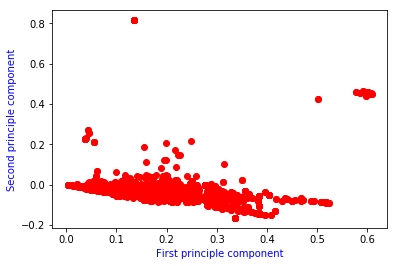

In [32]:
plt.plot(svd_matrix[:,0], svd_matrix[:,1], 'ro')
plt.xlabel("First principle component", color="blue")
plt.ylabel("Second principle component", color="blue")
plt.show()

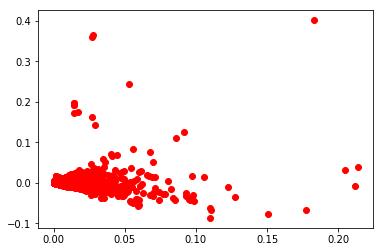

In [33]:
y = faculty_svd.components_.T
plt.plot(y[:,0], y[:,1], 'ro')
plt.show()

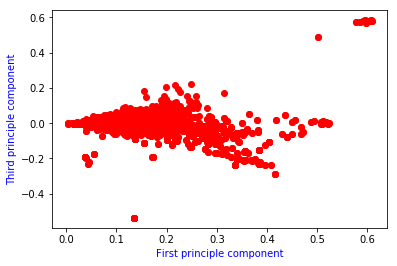

In [34]:
plt.plot(svd_matrix[:,0], svd_matrix[:,2], 'ro')
plt.xlabel("First principle component", color="blue")
plt.ylabel("Third principle component", color="blue")
plt.show()

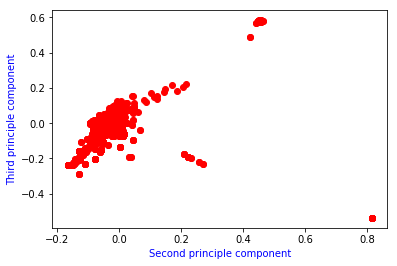

In [35]:
plt.plot(svd_matrix[:,1], svd_matrix[:,2], 'ro')
plt.xlabel("Second principle component", color="blue")
plt.ylabel("Third principle component", color="blue")
plt.show()

<b>PCA of faculty profiles</b>

In [36]:
faculty_pca = PCA(n_components=2)
pca_matrix = faculty_pca.fit(faculty_matrix.toarray()).transform(faculty_matrix.toarray())

In [37]:
pca_matrix.shape

(2420, 2)

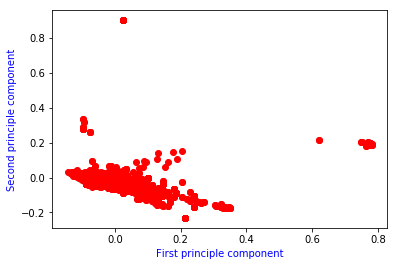

In [38]:
plt.plot(pca_matrix[:,0], pca_matrix[:,1], 'ro')
plt.xlabel("First principle component", color="blue")
plt.ylabel("Second principle component", color="blue")
plt.show()

In [40]:
x = faculty_pca.components_.T
x_axis = x[:,0]
print(np.argmax(x_axis))
print(x_axis[27069])
fac_vocab = faculty_vectorizer.vocabulary_
for key in fac_vocab.keys():
    if fac_vocab[key] == 27069:
        print(key)

27069
0.422597747417
law


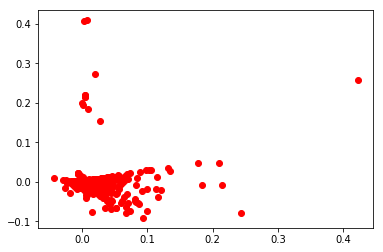

In [41]:
plt.plot(x[:,0], x[:,1], 'ro')
plt.show()

<b>SVD of grant profiles</b>

In [79]:
grant_svd = TruncatedSVD(n_components=10)
svd_matrix_2 = grant_svd.fit(grants_matrix).transform(grants_matrix)

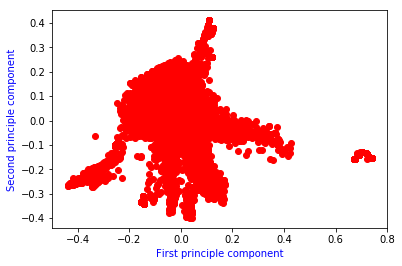

In [43]:
plt.plot(svd_matrix_2[:,2], svd_matrix_2[:,3], 'ro')
plt.xlabel("First principle component", color="blue")
plt.ylabel("Second principle component", color="blue")
plt.show()

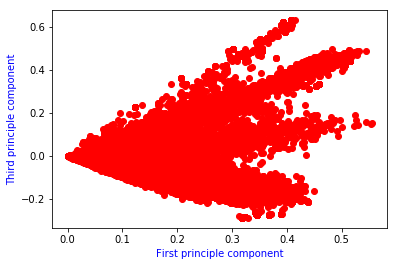

In [44]:
plt.plot(svd_matrix_2[:,0], svd_matrix_2[:,1], 'ro')
plt.xlabel("First principle component", color="blue")
plt.ylabel("Third principle component", color="blue")
plt.show()

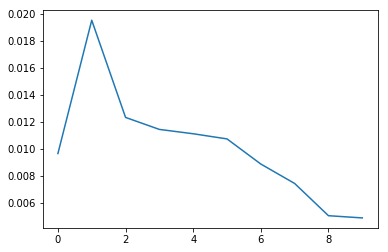

In [45]:
explained = grant_svd.explained_variance_ratio_
plt.plot(np.arange(explained.shape[0]), explained)
plt.show()

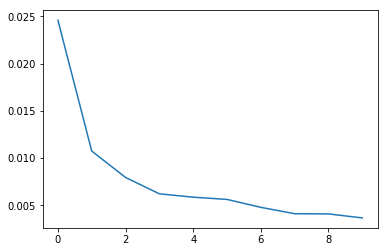

In [84]:
faculty_grant_svd = TruncatedSVD(n_components=10)
svd_matrix_2 = faculty_grant_svd.fit(faculty_grants_matrix).transform(faculty_grants_matrix)

explained = faculty_grant_svd.explained_variance_ratio_
plt.plot(np.arange(explained.shape[0]), explained)
plt.show()

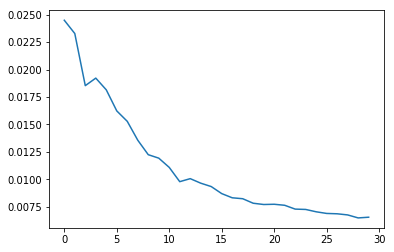

In [77]:
nsf_grant_svd = TruncatedSVD(n_components=30)
svd_matrix_2 = nsf_grant_svd.fit(nsf_matrix).transform(nsf_matrix)

explained = nsf_grant_svd.explained_variance_ratio_
plt.plot(np.arange(explained.shape[0]), explained)
plt.show()

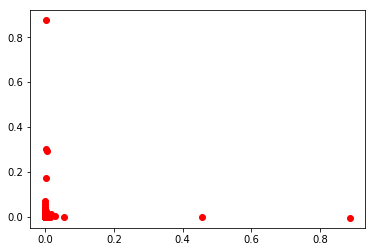

In [85]:
y = faculty_grant_svd.components_.T
plt.plot(y[:,0], y[:,1], 'ro')
plt.show()

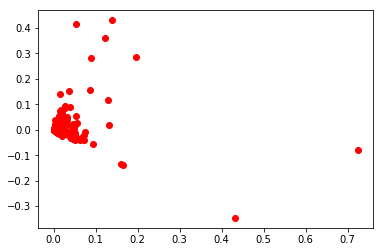

In [78]:
y = nsf_grant_svd.components_.T
plt.plot(y[:,0], y[:,1], 'ro')
plt.show()

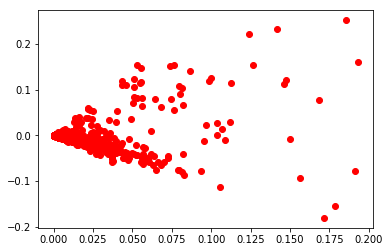

In [80]:
y = grant_svd.components_.T
plt.plot(y[:,0], y[:,1], 'ro')
plt.show()